In [1]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch import distributions

import numpy as np
torch.manual_seed(0)
np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

# from flow_ssl.realnvp.realnvp_toy import ToyRealNVP
from flow_ssl.realnvp.realnvp import TabularRealNVP
from flow_ssl.data import make_circles_ssl, make_moons_ssl, make_dataset_from_img, make_dataset_from_npz
from flow_ssl.distributions import SSLGaussMixture
from flow_ssl import FlowLoss

from itertools import chain

%load_ext autoreload
%autoreload 2

In [2]:
def grid_image(mapping, xx, yy, extradim=False):
    lines = np.hstack([xx.reshape([-1, 1]), yy.reshape([-1, 1])])
    if extradim:
        lines = lines[:, None, :]
    lines = torch.from_numpy(lines).float()
    img_lines = mapping(lines).detach().numpy()
    
    if extradim:
        img_xx, img_yy = img_lines[:, 0, 0], img_lines[:, 0, 1]
    else:
        img_xx, img_yy = img_lines[:, 0], img_lines[:, 1]
    img_xx = img_xx.reshape(xx.shape)
    img_yy = img_yy.reshape(yy.shape)
    return img_xx, img_yy

In [3]:
from scipy.spatial.distance import cdist

def get_decision_boundary(f_xx, f_yy, prior):
    f_points = np.hstack([f_xx.reshape([-1, 1]), f_yy.reshape([-1, 1])])
    classes = prior.classify(torch.from_numpy(f_points).float()).detach().numpy()
    return classes

## Moons

In [10]:
# r = 3.5
# means = torch.tensor([[-r, -r], [r, r]])

r = 3.5
n_classes = 2

phis = np.linspace(0, 2 * np.pi, n_classes+1)[:-1]
mean_x = np.cos(phis) * r
mean_y = np.sin(phis) * r
means = np.hstack([mean_x[:, None], mean_y[:, None]])
means = torch.from_numpy(means).float()


prior = SSLGaussMixture(means=means)

data, labels = make_moons_ssl()

flow = TabularRealNVP(num_coupling_layers=6, in_dim=2, num_layers=2, hidden_dim=256)
loss_fn = FlowLoss(prior)
# get_toy_nvp(D=2, prior=prior, device=None, inner_dim=256, coupling_layers_num=6, inner_layers=2)

In [11]:
lr_init = 1e-4
epochs = 2001

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 500

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    z = flow(batch_x)
    sldj = flow.logdet()

    loss = loss_fn(z, sldj, batch_y)
    
    optimizer.zero_grad()
    loss.backward()#retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

iter 0: loss = 19.819
iter 500: loss = 4.625
iter 1000: loss = 4.338
iter 1500: loss = 3.950
iter 2000: loss = 3.939


(-1.5, 2.5)

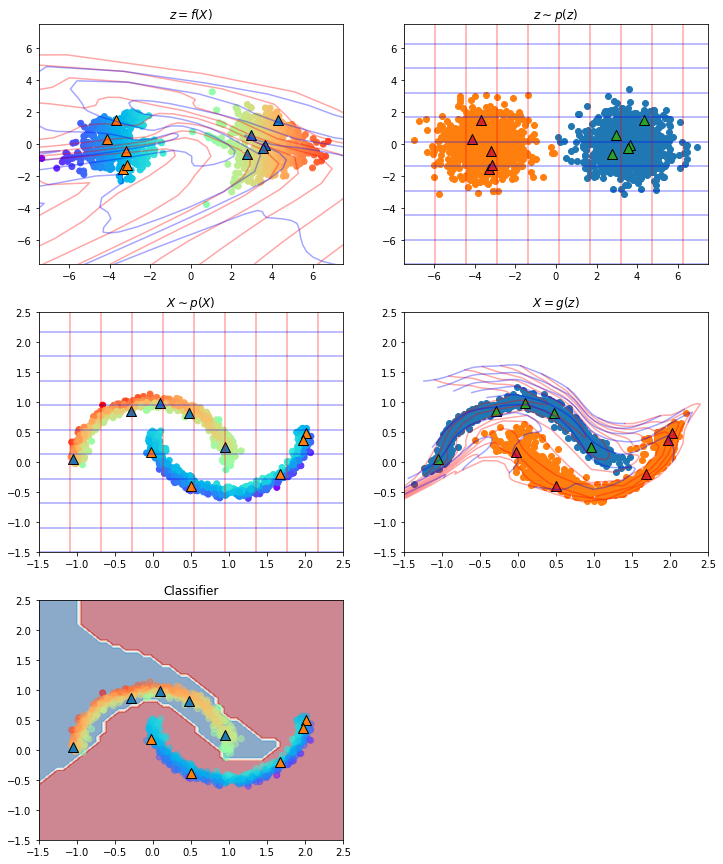

In [12]:
plt.figure(figsize=(12, 15))


grid_points = 50
grid_freq = 5
z_lims = np.array([-7.5, 7.5])
x_lims = np.array([-1.5, 2.5])
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow(torch.from_numpy(data)).detach().numpy()

plt.subplot(321)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(flow, xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx_, f_yy_ = grid_image(flow, yy_x, xx_x)
plt.plot(f_xx_[:, ::grid_freq], f_yy_[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(322)
zs = []
for i in range(len(means)):
    z = loss_fn.prior.sample((1000,), gaussian_id=i).numpy()
    zs.append(z)
    plt.scatter(z[:, 0], z[:, 1], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)


plt.subplot(324)
g_xx, g_yy = grid_image(flow.inverse, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx_, g_yy_ = grid_image(flow.inverse, yy_z, xx_z)
plt.plot(g_xx_[:, ::grid_freq], g_yy_[:, ::grid_freq], '-b', alpha=0.35)
xs = []

for z in zs:
    x = flow.inverse(torch.from_numpy(z).float()).detach().numpy()
    plt.scatter(x[:, 0], x[:, 1], cmap=plt.cm.rainbow)
    xs.append(x)
    
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(325)
classes = get_decision_boundary(f_xx, f_yy, prior)
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)

# np.savez("../plots/data/toy_moons.npz", 
#          data=data, labels=labels, inv=inv,
#          xx_x=xx_x, yy_x=yy_x, xx_z=xx_z, yy_z=yy_z,
#          g_xx=g_xx, g_yy=g_yy, g_xx_=g_xx_, g_yy_=g_yy_,
#          f_xx=f_xx, f_yy=f_yy, f_xx_=f_xx_, f_yy_=f_yy_,
#          x_lims=x_lims, z_lims=z_lims,
#          zs=zs, xs=xs,
#          classes=classes,
#         )

## Circles

In [13]:
r = 3.5
means = torch.tensor([[r, -r], [-r, r]])
prior = SSLGaussMixture(means=means)

data, labels = make_circles_ssl()

flow = TabularRealNVP()
loss_fn = FlowLoss(prior)

In [ ]:
lr_init = 1e-4
epochs = 5001

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 500

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    z = flow(batch_x)
    sldj = flow.logdet()

    loss = loss_fn(z, sldj, batch_y)
    
    optimizer.zero_grad()
    loss.backward()#retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

iter 0: loss = 24.659
iter 500: loss = 4.673
iter 1000: loss = 4.292
iter 1500: loss = 4.233
iter 2000: loss = 4.043


(-1.5, 1.5)

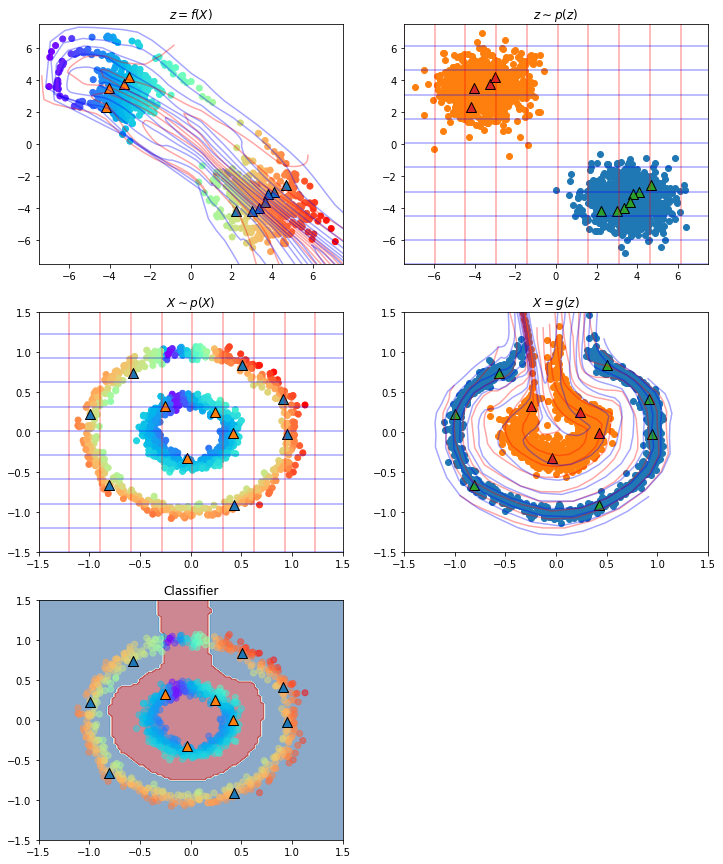

In [16]:
plt.figure(figsize=(12, 15))


grid_points = 100
grid_freq = 10
z_lims = [-7.5, 7.5]
x_lims = [-1.5, 1.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow(torch.from_numpy(data)).detach().numpy()

plt.subplot(321)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(flow, xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx_, f_yy_ = grid_image(flow, yy_x, xx_x)
plt.plot(f_xx_[:, ::grid_freq], f_yy_[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(322)
zs = []
for i in range(len(means)):
    z = loss_fn.prior.sample((1000, 1), gaussian_id=i).numpy()
    zs.append(z)
    plt.scatter(z[:, 0, 0], z[:, 0, 1], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)


plt.subplot(324)
g_xx, g_yy = grid_image(flow.inverse, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx_, g_yy_ = grid_image(flow.inverse, yy_z, xx_z)
plt.plot(g_xx_[:, ::grid_freq], g_yy_[:, ::grid_freq], '-b', alpha=0.35)
xs = []

for z in zs:
    x = flow.inverse(torch.from_numpy(z).float()).detach().numpy()
    plt.scatter(x[:, 0, 0], x[:, 0, 1], cmap=plt.cm.rainbow)
    xs.append(x)
    
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(325)
classes = get_decision_boundary(f_xx, f_yy, prior)
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)

## 8 Gaussians

In [21]:
r = 5.5
n_classes = 3

phis = np.linspace(0, 2 * np.pi, n_classes+1)[:-1]
mean_x = np.cos(phis) * r
mean_y = np.sin(phis) * r
means = np.hstack([mean_x[:, None], mean_y[:, None]])
means = torch.from_numpy(means).float()
prior = SSLGaussMixture(means=means)

data, labels = make_dataset_from_npz("../../data/toy_datasets/8gauss.npz")

flow = ToyRealNVP()
loss_fn = FlowLoss(prior)

In [22]:
lr_init = 1e-4
epochs = 5001

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 500

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    z = flow(batch_x)
    sldj = flow.logdet()

    loss = loss_fn(z, sldj, batch_y)
    
    optimizer.zero_grad()
    loss.backward()#retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

iter 0: loss = 31.662
iter 500: loss = 13.126
iter 1000: loss = 13.013
iter 1500: loss = 12.683
iter 2000: loss = 12.668
iter 2500: loss = 12.935
iter 3000: loss = 12.723
iter 3500: loss = 12.640
iter 4000: loss = 12.693
iter 4500: loss = 12.595
iter 5000: loss = 12.691


(-4.5, 4.5)

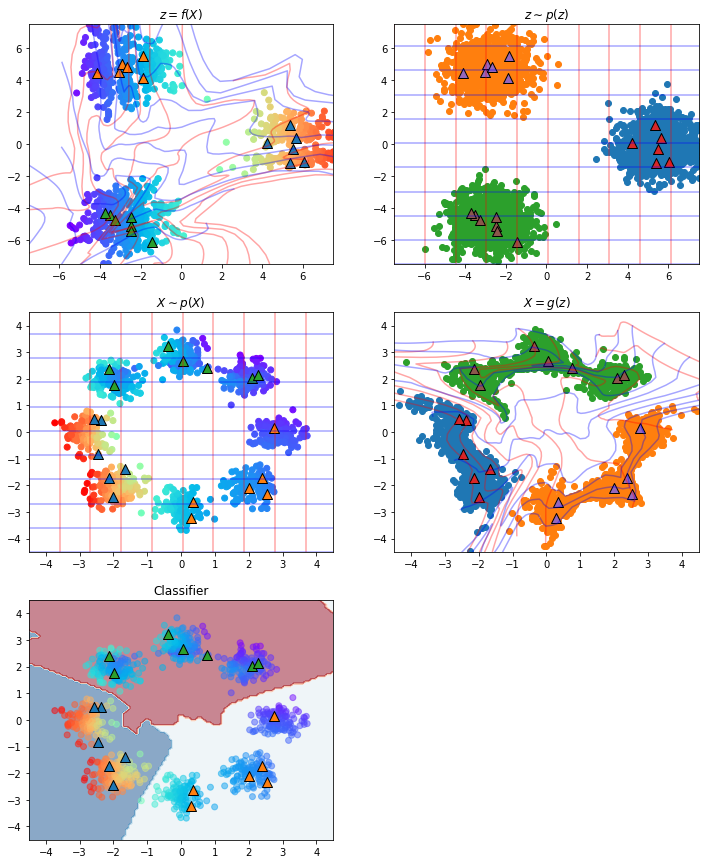

In [23]:
plt.figure(figsize=(12, 15))


grid_points = 100
grid_freq = 10
z_lims = [-7.5, 7.5]
x_lims = [-4.5, 4.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow(torch.from_numpy(data)).detach().numpy()

plt.subplot(321)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(flow, xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx_, f_yy_ = grid_image(flow, yy_x, xx_x)
plt.plot(f_xx_[:, ::grid_freq], f_yy_[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(322)
zs = []
for i in range(len(means)):
    z = loss_fn.prior.sample((1000, 1), gaussian_id=i).numpy()
    zs.append(z)
    plt.scatter(z[:, 0, 0], z[:, 0, 1], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)


plt.subplot(324)
g_xx, g_yy = grid_image(flow.inverse, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx_, g_yy_ = grid_image(flow.inverse, yy_z, xx_z)
plt.plot(g_xx_[:, ::grid_freq], g_yy_[:, ::grid_freq], '-b', alpha=0.35)
xs = []

for z in zs:
    x = flow.inverse(torch.from_numpy(z).float()).detach().numpy()
    plt.scatter(x[:, 0, 0], x[:, 0, 1], cmap=plt.cm.rainbow)
    xs.append(x)
    
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(325)
classes = get_decision_boundary(f_xx, f_yy, prior)
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)

## Pinwheel

In [4]:
r = 5.5
n_classes = 5

phis = np.linspace(0, 2 * np.pi, n_classes+1)[:-1]
mean_x = np.cos(phis) * r
mean_y = np.sin(phis) * r
means = np.hstack([mean_x[:, None], mean_y[:, None]])
means = torch.from_numpy(means).float()
prior = SSLGaussMixture(means=means)

data, labels = make_dataset_from_npz("../../data/toy_datasets/pinwheel.npz")

flow = ToyRealNVP()
loss_fn = FlowLoss(prior)

In [5]:
lr_init = 1e-4
epochs = 5001

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 500

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
for t in range(epochs):    
    
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    z = flow(batch_x)
    sldj = flow.logdet()

    loss = loss_fn(z, sldj, batch_y)
    
    optimizer.zero_grad()
    loss.backward()#retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

iter 0: loss = 21.734
iter 500: loss = 11.897
iter 1000: loss = 12.064
iter 1500: loss = 11.578
iter 2000: loss = 12.065
iter 2500: loss = 11.406
iter 3000: loss = 11.720
iter 3500: loss = 12.020
iter 4000: loss = 11.785
iter 4500: loss = 11.359
iter 5000: loss = 11.715


(-4.5, 4.5)

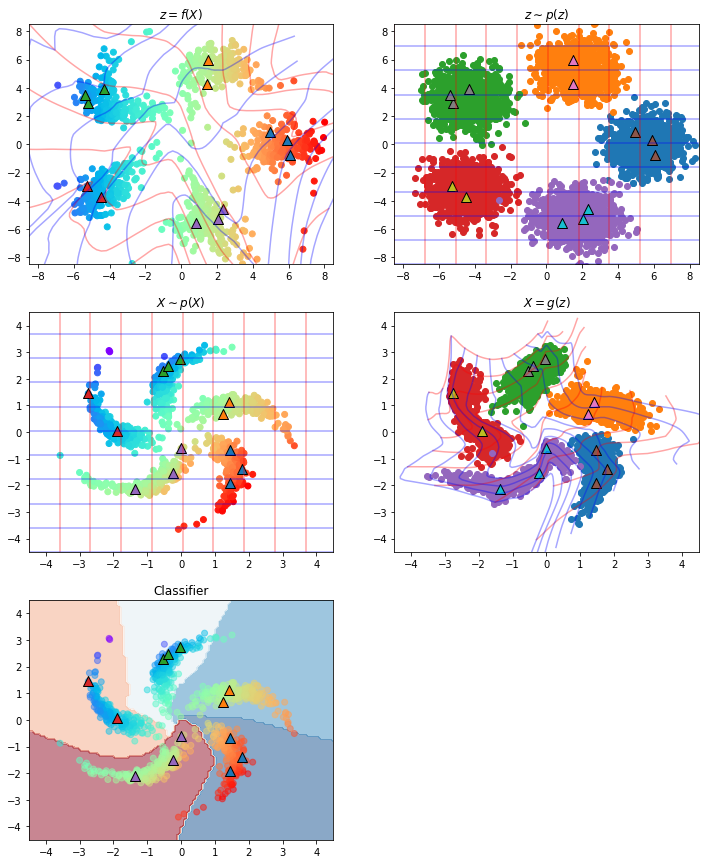

In [6]:
plt.figure(figsize=(12, 15))


grid_points = 100
grid_freq = 10
z_lims = [-8.5, 8.5]
x_lims = [-4.5, 4.5]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow(torch.from_numpy(data)).detach().numpy()

plt.subplot(321)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(flow, xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx_, f_yy_ = grid_image(flow, yy_x, xx_x)
plt.plot(f_xx_[:, ::grid_freq], f_yy_[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(322)
zs = []
for i in range(len(means)):
    z = loss_fn.prior.sample((1000, 1), gaussian_id=i).numpy()
    zs.append(z)
    plt.scatter(z[:, 0, 0], z[:, 0, 1], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)


plt.subplot(324)
g_xx, g_yy = grid_image(flow.inverse, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx_, g_yy_ = grid_image(flow.inverse, yy_z, xx_z)
plt.plot(g_xx_[:, ::grid_freq], g_yy_[:, ::grid_freq], '-b', alpha=0.35)
xs = []

for z in zs:
    x = flow.inverse(torch.from_numpy(z).float()).detach().numpy()
    plt.scatter(x[:, 0, 0], x[:, 0, 1], cmap=plt.cm.rainbow)
    xs.append(x)
    
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(325)
classes = get_decision_boundary(f_xx, f_yy, prior)
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)


## Cat

In [25]:
means = torch.zeros((1, 2))
prior = SSLGaussMixture(means=means)

data, labels = make_dataset_from_img("../../data/toy_datasets/img/github.png")

flow = ToyRealNVP()
loss_fn = FlowLoss(prior)

In [26]:
lr_init = 3e-4
epochs = 5001

batch_size = 100
print_freq = 500

unlabeled_data = data
unlabeled_labels = labels

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
for t in range(epochs):    
    
    batch_idx = np.random.choice(len(data), size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    z = flow(batch_x)
    sldj = flow.logdet()

    loss = loss_fn(z, sldj, batch_y)
    
    optimizer.zero_grad()
    loss.backward()#retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

iter 0: loss = 15.725
iter 500: loss = 14.504
iter 1000: loss = 14.422
iter 1500: loss = 14.430
iter 2000: loss = 14.431
iter 2500: loss = 14.437
iter 3000: loss = 14.451
iter 3500: loss = 14.432
iter 4000: loss = 14.401
iter 4500: loss = 14.414
iter 5000: loss = 14.428


(-4, 4)

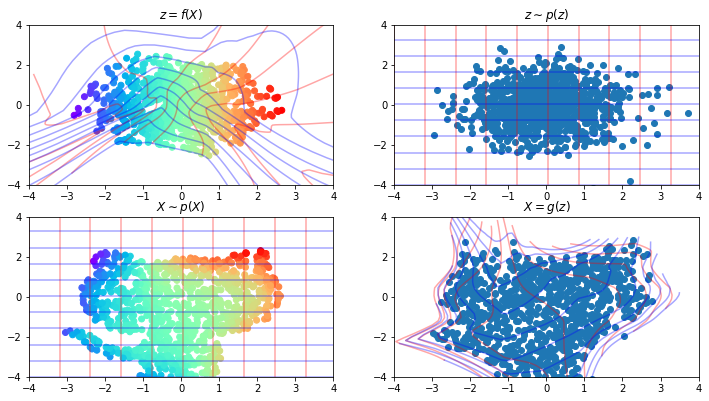

In [27]:
plt.figure(figsize=(12, 10))


grid_points = 100
grid_freq = 10
z_lims = [-4, 4]
x_lims = [-4, 4]
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow(torch.from_numpy(data)).detach().numpy()

plt.subplot(321)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(flow, xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx_, f_yy_ = grid_image(flow, yy_x, xx_x)
plt.plot(f_xx_[:, ::grid_freq], f_yy_[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(322)
zs = []
for i in range(len(means)):
    z = loss_fn.prior.sample((1000, 1), gaussian_id=i).numpy()
    zs.append(z)
    plt.scatter(z[:, 0, 0], z[:, 0, 1], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)


plt.subplot(324)
g_xx, g_yy = grid_image(flow.inverse, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx_, g_yy_ = grid_image(flow.inverse, yy_z, xx_z)
plt.plot(g_xx_[:, ::grid_freq], g_yy_[:, ::grid_freq], '-b', alpha=0.35)
xs = []

for z in zs:
    x = flow.inverse(torch.from_numpy(z).float()).detach().numpy()
    plt.scatter(x[:, 0, 0], x[:, 0, 1], cmap=plt.cm.rainbow)
    xs.append(x)
    
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)